
#            Calcul numérique du MGI d'un RRR par PNL #



On se propose de calculer de manière numérique un modèle géométrique inverse (MGI) d'un robot RRR en utilisant les outils de programmation non-linéaire. 

La configuration du robot est défini par le vecteur $q = (q_1, q_2, q_3)^t$.

La situation de l'outil est défini par le vecteur $X = (x, y, z)^t$ .

|![alternative text](robot-rrr3.png)|
|:--:| 
| *  Robot RRR  * |

## Objectif
L'objectif est d'implémenter plusieurs méthodes de recherche de solution pour le calcul du MGI (recherche d'un optimum local), de les comparer et d'en tirer des conclusions. 

Les conditions de sortie des algorithmes seront définies par un nombre
maximum d'itérations et par une valeur seuil pour l'erreur de la fonction objectif.


## Principe

Pour calculer le MGI avec les outils de programmation non linéaire vous devez :

- définir une fonction à minimiser ou à annuler

- implémenter une méthode de recherche linéaire


## Environnement Python et liste des modules utiles


In [1]:
## Environnement Python
################################################# 
import numpy as np
import scipy
import time
##############
%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d  # Fonction pour la 3D
from mpl_toolkits.mplot3d import proj3d
#############
from scipy.optimize import minimize
from scipy.optimize import root
import scipy.optimize as spop
from scipy import linalg


## Calcul du MGD


In [2]:
#################################################   
# Calcul du MGD du robot RRR
# INPUT:  q = vecteur de configuration (deg, deg, deg)
# OUTPUT: Xc = vecteur de situation = position3D = (x,y,z) 
def mgd(qdeg,a,b):
    qrad=np.deg2rad(qdeg)
    c1= np.cos(qrad[0])
    s1=np.sin(qrad[0])
    c23= np.cos(qrad[2]+qrad[1])
    s23= np.sin(qrad[2]+qrad[1])
    c2=np.cos(qrad[1])
    s2=np.sin(qrad[1])
    x= a*c1*c2 + b*c1*c23
    y= a*s1*c2 + b*s1*c23
    z= a*s2 + b*s23
    Xd=[x,y,z]
    return Xd

### Test du MGD

In [3]:
##### INPUT de q en degré ###
qdeg = [90, 0, 90]
Xd= mgd(qdeg,1,1)
print("X=", Xd[0], "Y = ", Xd[1], "Z= ",Xd[2])

X= 6.123233995736766e-17 Y =  1.0 Z=  1.0


## Calcul de la Jacobienne analytique Ja(q)

In [4]:
#################################################   
# Calcul de J(q) du robot RRR
# INPUT:  q = vecteur de configuration (deg, deg, deg)
# OUTPUT: jacobienne(q) analytique:
def ja(qdeg,a,b):
#### Paramètres du robot
    a,b=10,10
    qrad=np.deg2rad(qdeg)
    c1= np.cos(qrad[0])
    s1=np.sin(qrad[0])
    c23= np.cos(qrad[2]+qrad[1])
    s23= np.sin(qrad[2]+qrad[1])
    c2=np.cos(qrad[1])
    s2=np.sin(qrad[1])
 
    Ja=np.array([[-a*s1*c2 -b*s1*c23, -a*c1*s2 -b*c1*s23,  -b*c1*s23], 
                [a*c1*c2 + b*c1*c23, -a*s1*s2 -b*s1*s23,  -b*s1*s23], 
                 [0, a*c2 + b*c23, b*c23]])

    return Ja

### Test de J

In [5]:
qdeg = [90, 0, 90]
Ja=ja(qdeg,1,1)
print("Ja=",Ja)

Ja= [[-1.000000e+01 -6.123234e-16 -6.123234e-16]
 [ 6.123234e-16 -1.000000e+01 -1.000000e+01]
 [ 0.000000e+00  1.000000e+01  6.123234e-16]]


### Dessin du robot en 3D (filaire)

In [6]:
def dessinRRR(q,a,b) :
    qrad=np.deg2rad(q)
    c1= np.cos(qrad[0])
    s1=np.sin(qrad[0])
    c23= np.cos(qrad[2]+qrad[1])
    s23= np.sin(qrad[2]+qrad[1])
    c2=np.cos(qrad[1])
    s2=np.sin(qrad[1])
    
    X=[0, a*c1*c2, a*c1*c2 + b*c1*c23]
    Y=[0, a*s1*c2, a*s1*c2 + b*s1*c23]
    Z=[0, a*s2, a*s2 + b*s23]
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')  # Affichage en 3D
    ax.plot3D(X,Y,Z, 'red')
    
    plt.title("Tracé filaire")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.scatter(X,Y,Z, c="red")
    plt.show()

### Affichage du robot en 3D

In [7]:
%matplotlib qt
dessinRRR(qdeg,5,5)

In [8]:
%matplotlib inline

# ===========================================

# Travail à faire

Vous devez définir et implémenter la fonction de calcul du mgi: 

$[q_{sol}]= mgi(X_d, q_0, Nbmax, \epsilon$) 

avec 

- $X_d$ situation désirée, 
- $q_0$ configuration initiale du robot,
- $Nbmax$ nombre maximum d'itérations, 
- $\epsilon$ précision du calcul de la solution.

en utilisant une des méthodes proposées.

## 1 - Méthode du gradient

On utilise la méthode du gradient pour minimiser un critère $C(q)= \frac{1}{2} \; e^t.e = \frac{1}{2} \; \left\lVert e \right\rVert^{2}$ avec $e= X_d -f(q)$, $f(q)$ correspond au MGD en $q$.

- Montrer que $direction = -\nabla C(q) = J(q)^t . e$.

- Implémenter la méthode du gradient pour résoudre le  MGI. Tester pour différentes conditions initiales (proches/loin de la solution, proches/loin de singularités. On choisira un coefficient $pas = 0.5$, puis on le fera varier. Quel coefficient semble le plus approprié ? 
- Tracer la variation de l'erreur. Comment régler le pas afin de garantir une convergence du gradient ? 
- Proposer et implémenter une solution de calcul automatique du pas.
- Modifer la longueur des corps (a = 1 ou 10, b = 1 ou 10). Avez-vous le même résultat ?
- Conclusions

In [8]:
###################################################################################
# Afin de donner une situation atteignable pour le robot,
# vous pouvez utiliser le mgd pour définir Xbut à partir d'une configuration en q
###################################################################################
## qbut est donné en degré
qbut= [0., 0,  -90.]
## Calcul Xbut à partir de qbut
Xbut= np.asarray(mgd(qbut,1,1))
print("Xbut=", Xbut[0], "Ybut =", Xbut[1], "Zbut =", Xbut[2])

Xbut= 1.0 Ybut = 0.0 Zbut = -1.0


In [65]:
a,b= 1,1
# Définition de Xbut
qbut= np.asarray([118., 22,  48.])
Xbut= np.asarray(mgd(qbut,a,b))
qinit=np.asarray([120., 25,  45.])
f=mgd(qinit,a,b)
e=Xbut-mgd(qinit,1,1)
print(e)
Cq=1/2*np.dot(e.transpose()*e)
print(Cq)
print(np.gradient(Cq))

[ 0.02830878  0.03955691 -0.04801167]
0.002335628438532612
[]


In [82]:
a,b= 1,1
# Définition de Xbut
qbut= np.asarray([118., 22,  48.])
Xbut= np.asarray(mgd(qbut,a,b))
qinit=np.asarray([120., 25,  45.])
f=mgd(qinit,a,b)
e=Xbut-mgd(qinit,1,1)
e=np.array(e)
v=np.array([1,2,3,4])
# print(v.transpose())
# print(v)
# print(e.T)
# print(e)
Cq=1/2*e.transpose()*e
print(Cq)
np.gradient(Cq)

[0.00040069 0.00078237 0.00115256]


array([0.00038168, 0.00037593, 0.00037019])

In [ ]:
def mgi(Xd):
    
    
    
    
    return q

In [67]:
########### A FAIRE ##################################  
def direction(qinit,Xd):
    e=Xd-mgd(qinit,1,1)
    Ja=ja(qinit,1,1)
    dir = np.dot(Ja.transpose(),e)
    # print(dir)
    return dir
a,b= 1,1
# Définition de Xbut
qbut= np.asarray([118., 22,  48.])
Xbut= np.asarray(mgd(qbut,a,b))
qinit=np.asarray([120., 25,  45.])
dire=direction(qinit,Xbut)

[-0.55294162 -0.8732071  -0.35311507]


In [70]:
########## A FAIRE ###########################
def pas(pas):
    p=pas
    return p

Xbut= [-0.59585518  1.12064061  1.31429921] <class 'numpy.ndarray'>
Xinit =  [-0.62416397  1.0810837   1.36231088]
[-0.55294162 -0.8732071  -0.35311507]
[-0.481581   -0.56714293 -0.19778204]
[-0.41703795 -0.37299591 -0.09933781]
[-0.35986161 -0.24990859 -0.0371597 ]
[-0.30983374 -0.17183971  0.0019908 ]
[-0.26638895 -0.12226215  0.02655136]
[-0.22883593 -0.09071122  0.04187793]
[-0.19646945 -0.0705685   0.05136257]
[-0.16862361 -0.0576499   0.05715115]
[-0.14469414 -0.04931012  0.06060057]
[-0.12414485 -0.04387601  0.06256891]
[-0.10650607 -0.0402886   0.06359903]
[-0.09136976 -0.037877    0.06403462]
[-0.07838306 -0.03621573  0.06409344]
[-0.06724181 -0.03503456  0.06391365]
[-0.05768433 -0.0341616   0.06358301]
[-0.04948572 -0.03348732  0.06315735]
[-0.04245286 -0.03294178  0.06267227]
[-0.03642001 -0.03248021  0.06215049]
[-0.03124495 -0.03207389  0.06160656]
[-0.02680566 -0.03170431  0.06104983]
[-0.02299749 -0.03135953  0.0604863 ]
[-0.01973067 -0.03103182  0.05991985]
[-0.0169281

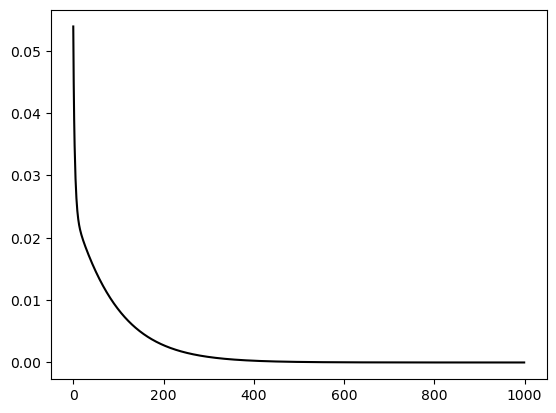

In [113]:
######### CALCUL DU MGI A FAIRE ################
# Définir les paramètres du robot
a,b= 1,1
# Définition de Xbut
qbut= np.asarray([118., 22,  48.])
Xbut= np.asarray(mgd(qbut,a,b))
print("Xbut=", Xbut, type(Xbut))
#Initialisation de la recherche
qinit=np.asarray([120., 25,  45.])
Xinit=np.asarray(mgd(qinit,a,b))
print("Xinit = ",Xinit)
#
# Algo de recherche de la solution
err = np.linalg.norm(qinit)
qavant = qinit
listeerr=[]
Nb=0
while (err > 0.01 or Nb < 1000):
    dir=direction(qavant,Xbut)
    # print(qavant)
    qsuiv=qavant+np.dot(pas(0.5),dir)
    # print(qsuiv)
    err=np.linalg.norm(Xbut-mgd(np.asarray(qsuiv),1,1))
    qavant=qsuiv
    listeerr.append(err)
    Nb=Nb+1
    # err = np.linalg.norm(err)
    # print(err)

# plt.plot(abs,listeerr,'k')
# plt.show(block=True)

# print(qsuiv)
# print(err)
    # qsuiv[0] = qavant[0]+pas(0.5)*direction(qavant[0],Xbut)
    # qsuiv[1] = qavant[1]+pas(0.5)*direction(qavant[1],Xbut)
    # qsuiv[2] = qavant[2]+pas(0.5)*direction(qavant[2],Xbut)
#
# qc = mgi(X,qinit,Nb,err) #valeur finale retournée par MGI
# Visualisation des résultats (quelques idées, faire une courbe 
# qui montre l'évolution de l'erreur)
# print("Valeur finale du critère =X",erx," après ",i," itérations")
# X= mgd(qc,a,b)
# print("Xinit              =",Xinit)
# print("Xfinal avec qfinal = ",X)
# print("Xbut à atteindre   =", Xbut)

# print("Erreur finale=",erx)
abs = np.linspace(0,len(listeerr)-1,(len(listeerr)))

plt.plot(abs,listeerr,'k')
plt.show(block=True)


## 2 - Méthode de Newton

On utilise le schéma de Newton pour calculer le MGI du robot en cherchant le zéro de la fonction:

$H(q) = X_d - f(q)$ 

pour une situation désirée $X_d = (x, y,\theta)^t$ avec $f(q)$ qui correspond au MGD en $q$.
Ce schéma impose de calculer l'inverse de la jacobienne analytique.

- Montrer que $ direction = J(q)^{-1} . (X_d - f(q)) $.
- Implémenter la méthode de Newton en python pour résoudre le MGI. Tester pour différentes conditions initiales(proches/loin de la solution, proches/loin de singularités. Modifier la valeur du $pas$. Faire varier  $N_{max}$ et $\epsilon$.
- Tracer la variation de l'erreur. Conclusions.


In [ ]:
################################################  
# calcul de la direction

In [ ]:
#################################################
# calcul du pas

In [ ]:
######### CALCUL DU MGI A FAIRE ################

# Conclusion

Donner vos conclusion sur l'utilisation de techniques de PNL pour le calcul de solutions de MGI

## 3 - Génération de mouvement en ligne droite

Réaliser un programme qui utilise le calcul numérique du MGI pour faire déplacer le robot en ligne droite entre deux points $A$ et $B$ définis dans l'espce de travail 3D.

A la situation initiale on connaît toujours la configuration $\bf{q}_0$ du robot (lecture des valeurs des codeurs).

Il faudra échantillonner le segment $AB$ pour définir les situations intermédiaire à atteindre.

Donner vos conclusions en fonction des points $A$ et $B$ et de la valeur de votre échantillonnage.


In [ ]:
plt.close('all')